# YOLOv5 model Evaluation

The following code loads the YOLOv5 trained model and calculates evaluation metrics based on its perfromance against a testing set.

In [1]:
import torch
from pathlib import Path
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import io
from torch.utils.tensorboard import SummaryWriter

def update_confusion_matrix(matrix, matches, predictions, ground_truths, class_labels):
    for match in matches:
        true_class = int(match[1][0])  # ground truth class
        pred_class = int(match[0][0])  # predicted class
        matrix[true_class][pred_class] += 1
    
    for pred in predictions:
        if pred not in [m[0] for m in matches]:
            pred_class = int(pred[0])  
            matrix[-1][pred_class] += 1  
    
    for gt in ground_truths:
        if gt not in [m[1] for m in matches]:
            true_class = int(gt[0]) 
            matrix[true_class][-1] += 1 
            
    
def read_labels(label_path, img_width, img_height):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.split())
            # Converting from normalized to pixel coordinates
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            width = width_norm * img_width
            height = height_norm * img_height
            # New format will be [x_min, y_min, x_max, y_max]
            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)
            x_max = x_center + (width / 2)
            y_max = y_center + (height / 2)

            labels.append((class_id, [x_min, y_min, x_max, y_max]))
    return labels

def bbox_iou(box1, box2):
    inter_rect_x1 = max(box1[0], box2[0])
    inter_rect_y1 = max(box1[1], box2[1])
    inter_rect_x2 = min(box1[2], box2[2])
    inter_rect_y2 = min(box1[3], box2[3])
    # Intersection area
    inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

    # Union Area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union_area = box1_area + box2_area - inter_area

    # Calculating IoU
    iou = inter_area/union_area
    return iou

def match_predictions(predictions, ground_truths, iou_threshold=0.5):
    matches = []
    for pred in predictions:
        pred_class, pred_bbox = pred[0], pred[1]
        for gt in ground_truths:
            gt_class, gt_bbox = gt[0], gt[1]
            if pred_class == gt_class:
                iou = bbox_iou(pred_bbox, gt_bbox)
                if iou >= iou_threshold:
                    matches.append((pred, gt))
                    ground_truths.remove(gt)
                    break 

    return matches

TP, FP, FN = 0, 0, 0

# Loading the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=r"C:\Users\kyled\yolov5\runs\train\exp16\weights\best.pt")
testing_set_dir = Path(r"C:\Users\kyled\Downloads\yolo_formatted_testing_set\images")
testing_set_dir2 = Path(r"C:\Users\kyled\Downloads\yolo_formatted_testing_set\Labels")

num_classes = 10
class_labels = ['pizza', 'Mushroom', 'Pepperoni', 'Yellow Peppers', 'Black Olives', 'Onion', 'Ham', 'Tomato', 'Broccoli', 'Green Olives']

# Initializing confusion matrix with all zeros
confusion_matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)

for img_path in testing_set_dir.glob('*.jpg'):
    # Reading the ground truth labels for the current image
    label_path = testing_set_dir2 / (img_path.stem + '.txt')
    img = Image.open(img_path)
    img_width, img_height = img.size
    ground_truths = read_labels(label_path, img_width, img_height)
    results = model(img_path)
    predictions = results.xyxy[0].cpu().numpy() 
    formatted_predictions = [(pred[5], pred[:4].tolist()) for pred in predictions]

    matches = match_predictions(formatted_predictions, ground_truths)
    
    update_confusion_matrix(confusion_matrix, matches, formatted_predictions, ground_truths, class_labels)

# Updating counts for TP, FP, and FN
TP += len(matches)
FP += len(formatted_predictions) - len(matches)
FN += len(ground_truths) - len(matches)

# Calculating metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

log_dir = r"C:\Users\kyled\yolov5\runs\YOLOv5_tensorboard"
writer = SummaryWriter(log_dir)
writer.add_scalar('YOLOv5 Precision', precision)
writer.add_scalar('YOLOv5 Recall', recall)

# Log the confusion matrix as an image
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels + ['False Positives'], yticklabels=class_labels + ['False Negatives'])
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
fig.canvas.draw()

# Convert the plot to a TensorBoard compatible image
confusion_matrix_image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
confusion_matrix_image = confusion_matrix_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
writer.add_image('YOLOv5 Confusion Matrix', confusion_matrix_image, dataformats='HWC')

writer.close()


Using cache found in C:\Users\kyled/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-1-13 Python-3.11.5 torch-2.1.2+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
C:\Users\kyled\AppData\Local\Temp\ipykernel_25880\4161614595.py:129: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  confusion_matrix_image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


Number of pizzas detected: 1
Topping: Pepperoni, Count: 21


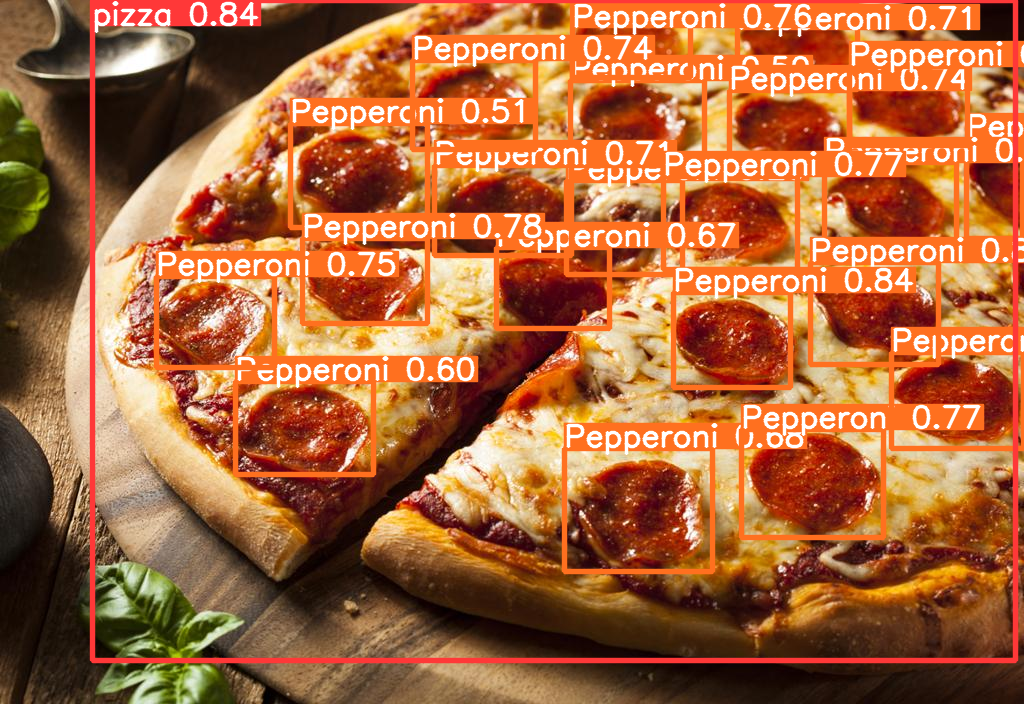

In [2]:
# Loading the image
img_path = r"C:\Users\kyled\Downloads\pizza_test.jpg"
img = Image.open(img_path)

results = model(img)

# Results contain bounding boxes and class names
detections = results.xyxy[0]  # xyxy is the bounding box format (x1, y1, x2, y2)

# Counting the number of pizzas and toppings
pizza_count = 0
topping_counts = {}

for *box, conf, cls_id in detections:
    class_name = results.names[int(cls_id)]
    if class_name == 'pizza':
        pizza_count += 1
    else:
        if class_name in topping_counts:
            topping_counts[class_name] += 1
        else:
            topping_counts[class_name] = 1

print(f"Number of pizzas detected: {pizza_count}")
for topping, count in topping_counts.items():
    print(f"Topping: {topping}, Count: {count}")
    
results.show()